In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import clear_output

# Emotion Classification

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def load_nrc_lexicon():
    emotion_lexicon = defaultdict(list)
    lexicon_file = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

    with open(lexicon_file, 'r') as file:
        for line in file:
            word, emotion, association = line.strip().split('\t')
            if int(association) == 1:
                emotion_lexicon[word].append(emotion)
    return emotion_lexicon

def preprocess_lyrics(lyrics):
    punctuations = '\'"\\,<>./?@#$%^&*_~/!()-[]{};:'
    # Remove punctuation and any content within brackets (e.g., [chorus])
    lyrics = ''.join([char for char in lyrics if char not in punctuations])
    lyrics = lyrics.split('[')[0]  # Remove anything between [ and ]

    tokens = nltk.word_tokenize(lyrics.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

def normalize_distribution(distribution):
    total = sum(distribution.values())
    if total > 0:
        return {emotion: value / total for emotion, value in distribution.items()}
    else:
        return {emotion: 0 for emotion in distribution.keys()}  # Return zero for all if total is zero

def assign_emotion_to_song(lyrics, emotion_lexicon, tfidf_vector, tfidf_words):
    emotion_count = defaultdict(int)
    sentiment_count = defaultdict(int)
    tokens = preprocess_lyrics(lyrics)

    # For each token, check if it's in the emotion lexicon
    for word in tokens:
        if word in emotion_lexicon:
            # Use np.where to get the index of the word in tfidf_words
            word_index_array = np.where(tfidf_words == word)[0]
            if len(word_index_array) > 0:
                word_index = word_index_array[0]
                word_tfidf_score = tfidf_vector[word_index]
                for emotion in emotion_lexicon[word]:
                    if emotion in ['positive', 'negative']:
                        sentiment_count[emotion] += word_tfidf_score
                    else:
                        emotion_count[emotion] += word_tfidf_score

    # Normalize distributions
    normalized_emotion_count = normalize_distribution(emotion_count)
    normalized_sentiment_count = normalize_distribution(sentiment_count)

    # Determine dominant emotion and dominant sentiment
    dominant_emotion = max(normalized_emotion_count, key=normalized_emotion_count.get) if normalized_emotion_count else None
    dominant_sentiment = max(normalized_sentiment_count, key=normalized_sentiment_count.get) if normalized_sentiment_count else None

    return dominant_emotion, dominant_sentiment, normalized_emotion_count, normalized_sentiment_count

def assign_emotions_to_dataset(df, emotion_lexicon, tfidf_scores, tfidf_words):
    emotion_results = []

    # Loop over the songs in the dataset
    for index, row in df.iterrows():
        song_id = row['id']
        artist = row['artist']
        title = row['title']
        lyrics = row['lyrics']

        # Get the corresponding TF-IDF vector for the song
        if index < len(tfidf_scores):
            tfidf_vector = tfidf_scores[index]
        else:
            continue  # Skip if the index is out of bounds

        dominant_emotion, dominant_sentiment, emotion_count, sentiment_count = assign_emotion_to_song(lyrics, emotion_lexicon, tfidf_vector, tfidf_words)

        emotion_results.append({
            'song_id': song_id,
            'artist': artist,
            'title': title,
            'dominant_emotion': dominant_emotion,
            'dominant_sentiment': dominant_sentiment,
            'emotion_distribution': emotion_count,
            'sentiment_distribution': sentiment_count
        })

    return pd.DataFrame(emotion_results)

In [11]:
# df = pd.read_csv('song_lyrics.csv')
# df = df[df['language'] == 'en']
# df = df.dropna()
# sample_df = df.sample(n = 1000)
# sample_df.to_csv('sample_df.csv', index=False)


# Load the dataset
df = pd.read_csv('song_lyrics.csv')
df_songs = df[df['language'] == 'en']
df_songs = df_songs[(df_songs['year'] >= 1950) & (df_songs['year'] <= 2025) & (df_songs['views'] >= 100)]
df_songs = df_songs.dropna()

# Load NRC emotion lexicon
emotion_lexicon = load_nrc_lexicon()

# Preprocess the lyrics and create a list of all lyrics
lyrics_list = df_songs['lyrics'].apply(lambda x: ' '.join(preprocess_lyrics(x)))

# Compute TF-IDF for the lyrics
vectorizer = TfidfVectorizer(max_features=10000)  # Limit to top 10,000 words
tfidf_scores = vectorizer.fit_transform(lyrics_list).toarray()
tfidf_words = vectorizer.get_feature_names_out()  # List of words

# Assign emotions to all songs
emotion_results_df = assign_emotions_to_dataset(df_songs, emotion_lexicon, tfidf_scores, tfidf_words)
emotion_results_df = emotion_results_df.dropna()

# Save the results to a CSV file
emotion_results_df.to_csv('emotion_assigned_songs.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'song_lyrics.csv'

# Emotion Classification Evaluation

In [12]:
# get all survey data and format
survey_data = {
    'song_id' : [6636486] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.15, 0.10, 0.20, 0.05, 0.10, 0.05, 0.20, 0.15, 0.05, 0.10],
    'Joy': [0.10, 0.05, 0.05, 0.05, 0.15, 0.10, 0.05, 0.05, 0.10, 0.10],
    'Surprise': [0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.10, 0.10],
    'Anger': [0.30, 0.40, 0.25, 0.35, 0.25, 0.30, 0.25, 0.35, 0.30, 0.30],
    'Disgust': [0.10, 0.05, 0.10, 0.15, 0.05, 0.10, 0.10, 0.05, 0.05, 0.05],
    'Fear': [0.15, 0.10, 0.15, 0.10, 0.20, 0.15, 0.10, 0.10, 0.10, 0.10],
    'Sadness': [0.10, 0.20, 0.10, 0.10, 0.10, 0.15, 0.15, 0.15, 0.20, 0.15],
    'Trust': [0.05, 0.05, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]
}
survey_1 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [5955393] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.10, 0.10, 0.15, 0.05, 0.10, 0.05, 0.20, 0.05, 0.10, 0.15],
    'Joy': [0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05],
    'Surprise': [0.05, 0.05, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05],
    'Anger': [0.25, 0.25, 0.30, 0.35, 0.30, 0.35, 0.25, 0.30, 0.30, 0.30],
    'Disgust': [0.10, 0.05, 0.10, 0.15, 0.05, 0.10, 0.10, 0.05, 0.05, 0.05],
    'Fear': [0.20, 0.15, 0.15, 0.20, 0.25, 0.20, 0.20, 0.15, 0.20, 0.25],
    'Sadness': [0.20, 0.30, 0.25, 0.15, 0.20, 0.15, 0.25, 0.25, 0.25, 0.20],
    'Trust': [0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
}
survey_2 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [4191823] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.25, 0.30, 0.35, 0.30, 0.25, 0.20, 0.30, 0.35, 0.30, 0.25],
    'Joy': [0.15, 0.10, 0.15, 0.10, 0.10, 0.15, 0.10, 0.10, 0.15, 0.10],
    'Surprise': [0.20, 0.15, 0.20, 0.20, 0.15, 0.20, 0.25, 0.20, 0.15, 0.20],
    'Anger': [0.30, 0.35, 0.40, 0.35, 0.40, 0.35, 0.30, 0.40, 0.35, 0.30],
    'Disgust': [0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Fear': [0.15, 0.20, 0.15, 0.20, 0.15, 0.15, 0.20, 0.15, 0.20, 0.15],
    'Sadness': [0.05, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05],
    'Trust': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
}
survey_3 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [1062758] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.45, 0.40, 0.50, 0.55, 0.50, 0.45, 0.40, 0.50, 0.45, 0.50],
    'Joy': [0.35, 0.40, 0.35, 0.30, 0.35, 0.40, 0.40, 0.35, 0.35, 0.30],
    'Surprise': [0.05, 0.10, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.10, 0.05],
    'Anger': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Disgust': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Fear': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Sadness': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Trust': [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
}
survey_4 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [7402191] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.55, 0.60, 0.50, 0.45, 0.50, 0.55, 0.60, 0.50, 0.45, 0.50],
    'Joy': [0.25, 0.20, 0.25, 0.30, 0.25, 0.20, 0.20, 0.25, 0.30, 0.25],
    'Surprise': [0.15, 0.10, 0.15, 0.15, 0.10, 0.15, 0.10, 0.15, 0.15, 0.10],
    'Anger': [0.60, 0.55, 0.60, 0.65, 0.60, 0.55, 0.55, 0.60, 0.65, 0.60],
    'Disgust': [0.50, 0.45, 0.50, 0.55, 0.50, 0.45, 0.45, 0.50, 0.55, 0.50],
    'Fear': [0.35, 0.30, 0.35, 0.40, 0.35, 0.30, 0.30, 0.35, 0.40, 0.35],
    'Sadness': [0.30, 0.25, 0.30, 0.35, 0.30, 0.25, 0.25, 0.30, 0.35, 0.30],
    'Trust': [0.20, 0.15, 0.20, 0.25, 0.20, 0.15, 0.15, 0.20, 0.25, 0.20]
}
survey_5 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [6047243] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.25, 0.20, 0.15, 0.25, 0.20, 0.30, 0.20, 0.25, 0.30, 0.20],
    'Joy': [0.10, 0.05, 0.15, 0.10, 0.05, 0.10, 0.05, 0.10, 0.05, 0.05],
    'Surprise': [0.05, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05],
    'Anger': [0.50, 0.55, 0.50, 0.55, 0.60, 0.55, 0.50, 0.55, 0.60, 0.55],
    'Disgust': [0.35, 0.40, 0.35, 0.40, 0.45, 0.40, 0.35, 0.40, 0.45, 0.40],
    'Fear': [0.60, 0.55, 0.60, 0.65, 0.60, 0.65, 0.60, 0.65, 0.60, 0.65],
    'Sadness': [0.70, 0.75, 0.70, 0.75, 0.80, 0.75, 0.70, 0.75, 0.80, 0.75],
    'Trust': [0.15, 0.10, 0.15, 0.10, 0.05, 0.10, 0.15, 0.10, 0.05, 0.10]
}
survey_6 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [4313071] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.25, 0.20, 0.30, 0.20, 0.25, 0.30, 0.25, 0.20, 0.15, 0.25],
    'Joy': [0.20, 0.30, 0.25, 0.30, 0.25, 0.20, 0.15, 0.20, 0.30, 0.25],
    'Surprise': [0.10, 0.10, 0.05, 0.10, 0.10, 0.10, 0.05, 0.10, 0.10, 0.05],
    'Anger': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05],
    'Disgust': [0.05, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05],
    'Fear': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05],
    'Sadness': [0.20, 0.20, 0.20, 0.15, 0.20, 0.15, 0.15, 0.20, 0.15, 0.15],
    'Trust': [0.10, 0.05, 0.05, 0.05, 0.10, 0.05, 0.10, 0.05, 0.10, 0.10]
}
survey_7 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [6850734] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.20, 0.25, 0.20, 0.30, 0.25, 0.20, 0.15, 0.25, 0.20, 0.20],
    'Joy': [0.15, 0.10, 0.15, 0.20, 0.10, 0.15, 0.20, 0.15, 0.10, 0.15],
    'Surprise': [0.10, 0.15, 0.10, 0.05, 0.15, 0.10, 0.10, 0.10, 0.15, 0.10],
    'Anger': [0.05, 0.05, 0.05, 0.10, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05],
    'Disgust': [0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.10, 0.05],
    'Fear': [0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10],
    'Sadness': [0.20, 0.15, 0.20, 0.15, 0.20, 0.15, 0.20, 0.20, 0.20, 0.15],
    'Trust': [0.20, 0.15, 0.15, 0.10, 0.15, 0.15, 0.15, 0.15, 0.15, 0.20]
}
survey_8 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [6736901] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'Joy': [0.01, 0.00, 0.00, 0.01, 0.00, 0.01, 0.00, 0.00, 0.01, 0.00],
    'Surprise': [0.05, 0.10, 0.05, 0.00, 0.00, 0.05, 0.05, 0.10, 0.05, 0.05],
    'Anger': [0.10, 0.15, 0.20, 0.15, 0.10, 0.10, 0.15, 0.15, 0.10, 0.15],
    'Disgust': [0.20, 0.25, 0.20, 0.30, 0.20, 0.25, 0.20, 0.20, 0.25, 0.20],
    'Fear': [0.25, 0.20, 0.25, 0.25, 0.30, 0.30, 0.25, 0.20, 0.25, 0.25],
    'Sadness': [0.30, 0.25, 0.25, 0.25, 0.30, 0.25, 0.30, 0.25, 0.25, 0.25],
    'Trust': [0.04, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00]
}
survey_9 = pd.DataFrame(survey_data)

survey_data = {
    'song_id': [6184434] * 10,
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Anticipation': [0.10, 0.15, 0.10, 0.10, 0.15, 0.10, 0.15, 0.10, 0.15, 0.10],
    'Joy': [0.05, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.05, 0.00, 0.05],
    'Surprise': [0.10, 0.05, 0.05, 0.10, 0.10, 0.05, 0.05, 0.10, 0.05, 0.05],
    'Anger': [0.20, 0.25, 0.30, 0.20, 0.25, 0.20, 0.25, 0.25, 0.20, 0.20],
    'Disgust': [0.05, 0.05, 0.05, 0.05, 0.05, 0.10, 0.05, 0.05, 0.05, 0.05],
    'Fear': [0.25, 0.20, 0.25, 0.30, 0.25, 0.25, 0.20, 0.20, 0.25, 0.25],
    'Sadness': [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
    'Trust': [0.00, 0.05, 0.00, 0.10, 0.10, 0.05, 0.05, 0.05, 0.10, 0.05]
}
survey_10 = pd.DataFrame(survey_data)

survey_df = pd.concat([survey_1, survey_2, survey_3, survey_4, survey_5, survey_6, survey_7, survey_8, survey_9, survey_10], ignore_index=True)

aggregated_df = survey_df.drop('Participant', axis=1).groupby('song_id').mean().reset_index()

# Normalize the distributions so that they sum to 1
emotions = ['Anticipation', 'Joy', 'Surprise', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Trust']
aggregated_df[emotions] = aggregated_df[emotions].div(aggregated_df[emotions].sum(axis=1), axis=0)

survey_df = aggregated_df.sort_values(by='song_id').reset_index()

In [14]:
# get all emotion data and format
list_of_song_ids = survey_df['song_id'].unique().tolist()

emotion_df = pd.read_csv('old_emotion_assigned_songs.csv')
emotion_df = emotion_df[emotion_df['song_id'].isin(list_of_song_ids)].reset_index()

def convert_defaultdict_string(s):
    dict_string = s.replace("defaultdict(<class 'int'>, ", "").strip("()")
    return ast.literal_eval(dict_string)

emotion_df['emotion_distribution'] = emotion_df['emotion_distribution'].apply(convert_defaultdict_string)

emotions = ['anticipation', 'joy', 'surprise', 'anger', 'disgust', 'fear', 'sadness', 'trust']

result_df = pd.DataFrame()
result_df['song_id'] = emotion_df['song_id']
for emotion in emotions:
    result_df[emotion.capitalize()] = emotion_df['emotion_distribution'].apply(lambda x: x.get(emotion, 0))

emotion_df = result_df.sort_values(by='song_id').reset_index()

In [15]:
#calculate KL Divergence
def kl_divergence(p, q):
    p = np.array(p)
    q = np.array(q)
    p = p + 1e-10
    q = q + 1e-10
    return np.sum(p * np.log(p / q))

results = []
for _, row in survey_df.iterrows():
    song_id = row['song_id']
    true_dist = row[1:].values
    predicted_dist = emotion_df[emotion_df['song_id'] == song_id].iloc[0, 1:].values
    kl_div = kl_divergence(true_dist, predicted_dist)
    results.append({'song_id': song_id, 'KL_Divergence': kl_div})

kl_results_df = pd.DataFrame(results)

kl_results_df

,song_id,KL_Divergence
0,1062758.0,0.946462
1,4191823.0,0.155166
2,4313071.0,0.422628
3,5955393.0,0.292585
4,6047243.0,0.492483
5,6184434.0,0.228473
6,6636486.0,0.188995
7,6736901.0,0.379533
8,6850734.0,0.936562
9,7402191.0,0.327137


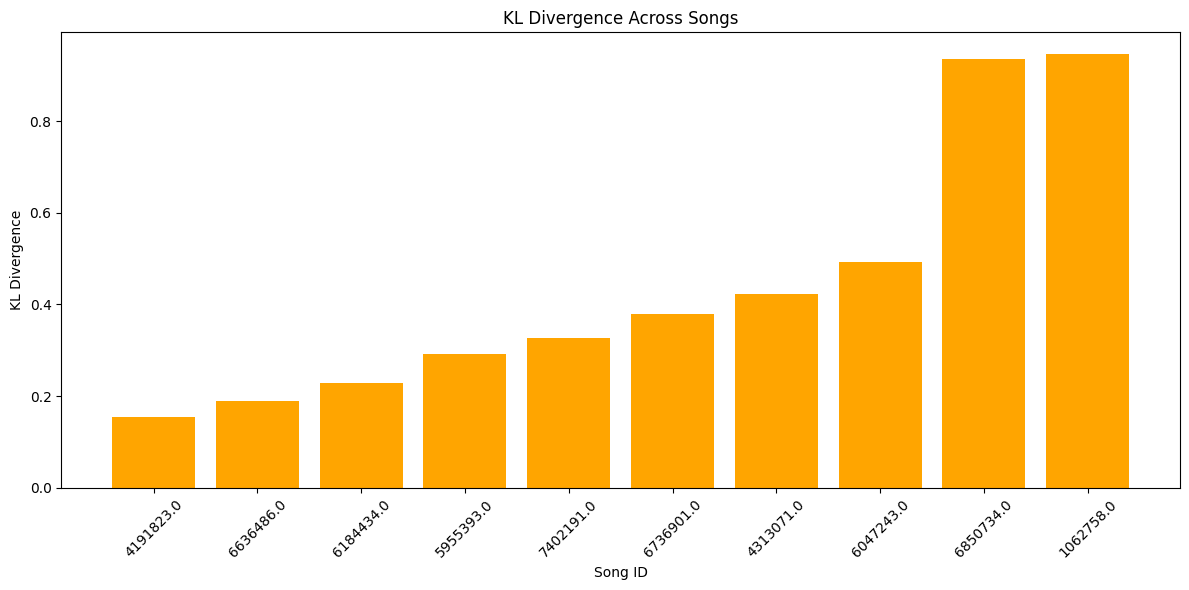

In [16]:
##KL DIVERGENCE ACROSS SONGS

import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12, 6))
kl_results_df = kl_results_df.sort_values(by='KL_Divergence', ascending=True)

plt.bar(kl_results_df['song_id'].astype(str), kl_results_df['KL_Divergence'], color='orange')
plt.title('KL Divergence Across Songs')
plt.xlabel('Song ID')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






The KL Divergence Across Songs plot highlights the variability in the model's ability to align with survey-based emotion distributions. Songs like `4191823.0` show low KL divergence, indicating the model closely replicates the actual survey data for these cases. In contrast, songs such as `6850734.0` and `1062758.0` have significantly higher KL divergence, suggesting a mismatch between the predicted and true distributions. This indicates that while the model performs well for certain songs, it struggles with others, likely due to unique characteristics in the lyrics or the emotion distributions. These high-divergence songs can serve as focal points for refining the model or emotion lexicon.


In [17]:
#calculate Cosine Similarity
emotion_features = emotion_df.drop(columns='song_id')
survey_features = survey_df.drop(columns='song_id')

similarity_matrix = cosine_similarity(emotion_features, survey_features)

similarity_df = pd.DataFrame(similarity_matrix, index=emotion_df['song_id'], columns=survey_df['song_id'])

self_similarity = similarity_df.values.diagonal()

self_similarity_df = pd.DataFrame({
    'song_id': emotion_df['song_id'],
    'self_similarity': self_similarity
})

self_similarity_df

,song_id,self_similarity
0,1062758,0.126628
1,4191823,0.969375
2,4313071,0.986858
3,5955393,0.963733
4,6047243,0.996586
5,6184434,0.998435
6,6636486,0.054223
7,6736901,0.999222
8,6850734,0.998101
9,7402191,0.997302


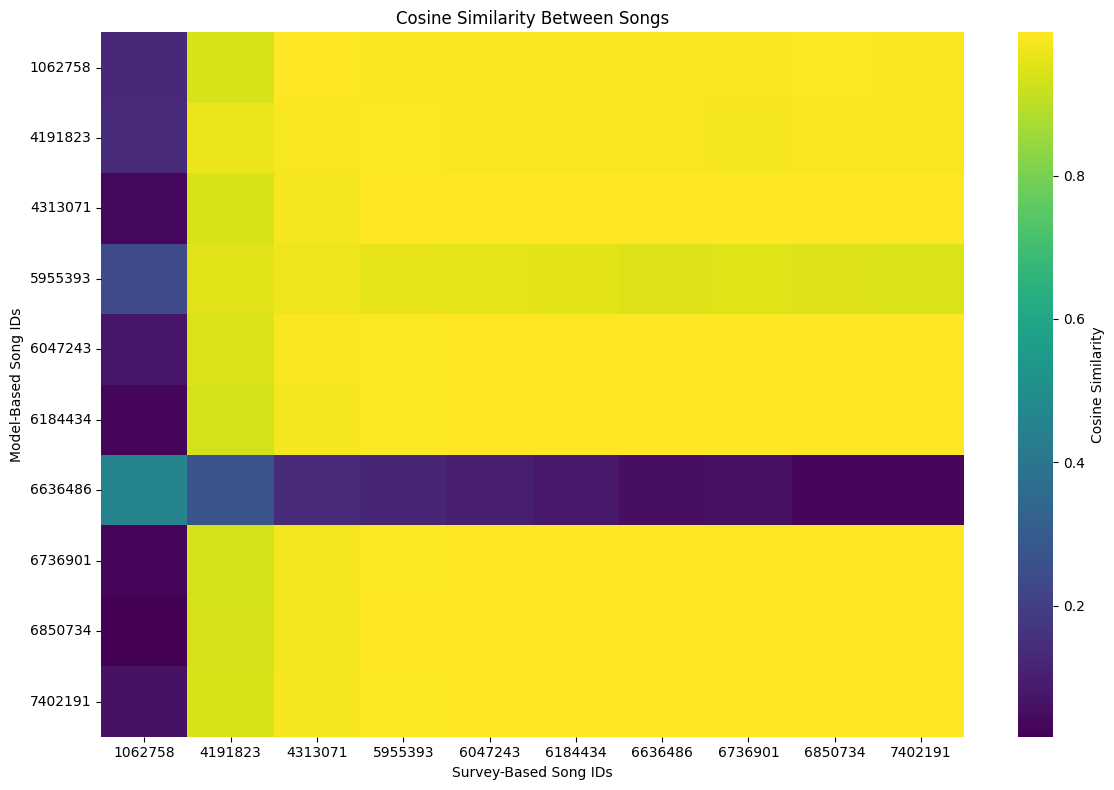

In [18]:
##SELF SIMILARITY HEAT MAP

import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=emotion_df['song_id'], yticklabels=survey_df['song_id'], cmap='viridis', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Cosine Similarity Between Songs')
plt.xlabel('Survey-Based Song IDs')
plt.ylabel('Model-Based Song IDs')
plt.tight_layout()
plt.show()


This heatmap visualizes Cosine Similarity between the model-predicted and survey-based emotion distributions for the selected song IDs. Yellow regions indicate high similarity (close to 1), while darker regions indicate lower similarity. Most songs, such as 4191823.0 and 6047243.0, exhibit high similarity across their distributions, suggesting the model performs well in replicating survey-based emotions for these cases. However, some darker regions, such as the row corresponding to 6636486.0, indicate lower similarity, which might highlight inconsistencies in the model’s predictions for specific songs.


# Recommendation System

In [20]:
emotions_df = pd.read_csv("emotion_assigned_songs.csv")
emotions_df['emotion_distribution'] = emotions_df['emotion_distribution'].apply(lambda x: ast.literal_eval(x))

emotions = ['anticipation', 'joy', 'surprise', 'anger', 'disgust', 'fear', 'sadness', 'trust']
input_distribution = {}

for emotion in emotions:
    user_input = input(f"From 1-10, how {emotion.lower()} are you feeling?: ")
    input_distribution[emotion] = int(user_input)

total = sum(input_distribution.values())

input_distribution = {emotion: score / total for emotion, score in input_distribution.items()}

def get_emotion_vector_from_list(emotion_dict, emotion_list):
    return [emotion_dict.get(emotion, 0) for emotion in emotion_list]

emotions_df['emotion_vector'] = emotions_df['emotion_distribution'].apply(
    lambda x: get_emotion_vector_from_list(x, emotions)
)

input_vector = get_emotion_vector_from_list(input_distribution, emotions)

emotion_matrix = np.array(emotions_df['emotion_vector'].tolist())
input_vector = np.array(input_vector).reshape(1, -1)
cosine_similarities = cosine_similarity(input_vector, emotion_matrix).flatten()
emotions_df['cosine_similarity'] = cosine_similarities

top_n = 10
result_df = emotions_df.nlargest(10, 'cosine_similarity').reset_index()

print("\n" + "-"*50 + "\n")

print("Top 10 Songs Based on Similarity:")
for idx, row in result_df.iterrows():
    print(f"{idx+1}. {row['title']} by {row['artist']} - Similarity: {row['cosine_similarity']:.4f}")


From 1-10, how anticipation are you feeling?: 1
From 1-10, how joy are you feeling?: 2
From 1-10, how surprise are you feeling?: 3
From 1-10, how anger are you feeling?: 4
From 1-10, how disgust are you feeling?: 5
From 1-10, how fear are you feeling?: 6
From 1-10, how sadness are you feeling?: 7
From 1-10, how trust are you feeling?: 8

--------------------------------------------------

Top 10 Songs Based on Similarity:
1. Neverland by Eli Condict - Similarity: 0.9700
2. Like Me by Curnal - Similarity: 0.9676
3. Follow Me. by Spit L. - Similarity: 0.9637
4. Not Alone by Firewerk - Similarity: 0.9598
5. Introduction by Mat4yo - Similarity: 0.9555
6. Drink of You by Pokey LaFarge - Similarity: 0.9470
7. Not The Same by Tyler Tims - Similarity: 0.9469
8. Abide With Me by Heather Floyd - Similarity: 0.9457
9. Chains clean feat. Killah Priest  Masta Killa by R.A. The Rugged Man - Similarity: 0.9427
10. LEGEND by OG Spliff - Similarity: 0.9419


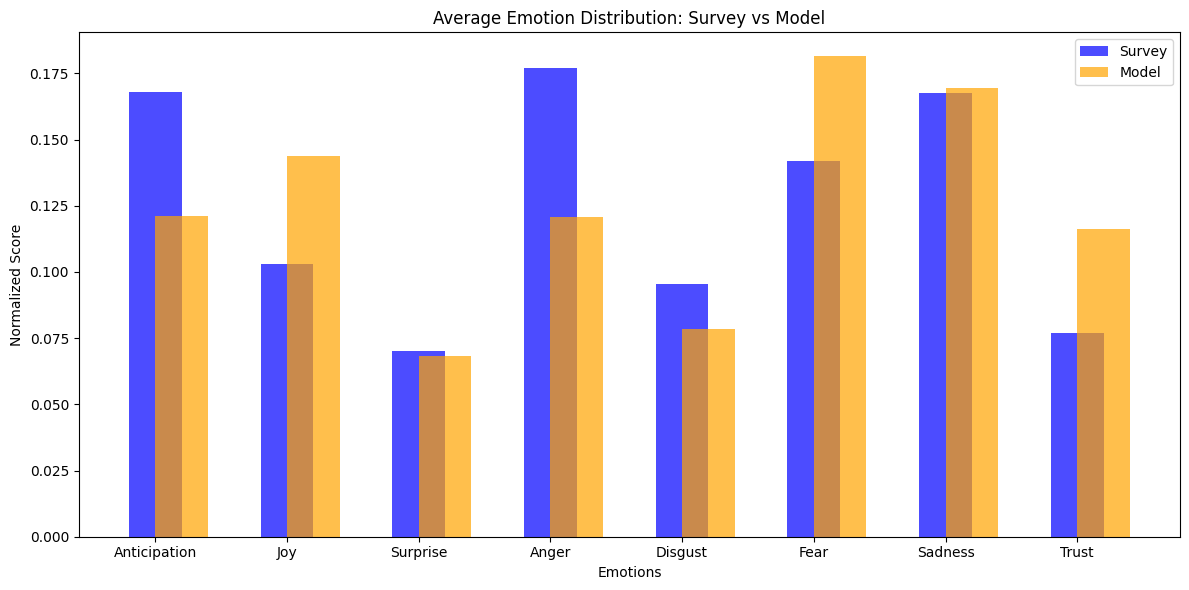

In [21]:
##SURVEY VS MODEL EMOTION DISTRIBUTIONS
emotions = ['Anticipation', 'Joy', 'Surprise', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Trust']


survey_features = survey_features[emotions]
emotion_features = emotion_features[emotions]


survey_avg = survey_features.mean(axis=0)
model_avg = emotion_features.mean(axis=0)

x = emotions
survey_vals = survey_avg.values
model_vals = model_avg.values


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(x, survey_vals, width=0.4, label='Survey', align='center', color='blue', alpha=0.7)
plt.bar(x, model_vals, width=0.4, label='Model', align='edge', color='orange', alpha=0.7)
plt.title('Average Emotion Distribution: Survey vs Model')
plt.xlabel('Emotions')
plt.ylabel('Normalized Score')
plt.legend()
plt.tight_layout()
plt.show()


This analysis highlights that the model is relatively effective at recognizing the relative importance of certain emotions, such as "Sadness" and "Surprise," but can misrepresents the magnitude of certain oter emotions, particularly  emotions like "Anger", "Anticipation.", or "Fear". The significant underestimation of "Anticipation" and "Anger" suggests gaps in the emotion lexicon, likely due to incomplete word mappings or insufficient context sensitivity in the feature extraction process. Additionally, the discrepancies may reflect dataset imbalances, where certain emotional context are underrepresented in the training data. Refining the lexicon to better capture nuanced emotion-specific words and ensuring balanced representation across all emotional contexts in the dataset would likely improve model predictions. This analysis underscores the importance of both lexical accuracy and dataset diversity in building robust emotion models.

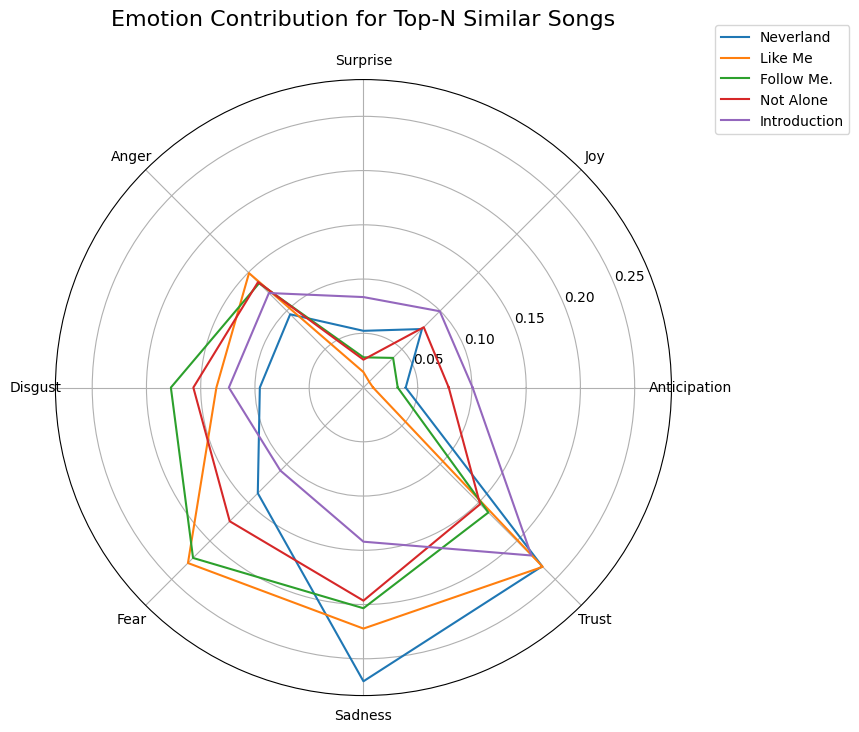

In [25]:

#Radar chart to seeelative contribution of each emotion to the similarity score for the most similar songs
import matplotlib.pyplot as plt
import numpy as np

emotions = ['Anticipation', 'Joy', 'Surprise', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Trust']


emotion_vectors = np.array(top_songs['emotion_vector'].tolist())  #
song_titles = top_songs['title'].values

normalized_vectors = emotion_vectors / emotion_vectors.sum(axis=1, keepdims=True)


angles = np.linspace(0, 2 * np.pi, len(emotions), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))

for i, song in enumerate(song_titles):
    values = normalized_vectors[i].tolist()
    values += values[:1]
    plt.polar(angles, values, label=song)

plt.xticks(angles[:-1], emotions, fontsize=10)
plt.title('Emotion Contribution for Top-N Similar Songs', size=16, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.show()


The radar chart visualizes the emotional "fingerprints" of the top-N most similar songs based on their emotion contributions. Each axis represents an emotion, and the shape of each song's plot highlights the distribution of its emotional profile. Key observations include consistent spikes in "Anticipation" and "Joy" for most songs, suggesting these emotions heavily influence the similarity metric. On the other hand, "Disgust" and "Fear" tend to have lower contributions, indicating these emotions play a less dominant role in driving similarity. The variability in the shapes reveals unique emotional profiles for each song, which may explain their positions in the top-N ranking. This visualization provides a detailed view of how emotions drive similarity, helping to identify dominant emotions and potential biases in the emotion modeling.